In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
class Multiclass_LDA_QDA:
    
    def __init__(self,analysis=None):
        self.x=None
        self.y=None
        self.analysis_type = analysis
    
    def fit(self,x,y):
        x=np.array(x)
        n_samples,n_features = x.shape
        self.weights = np.zeros(n_features) 
        self.bias = 0
        self.x = x
        self.y = y
        r = x.shape[0]
        l = list(np.unique(y))
        self.prob = np.zeros(len(l))
        self.cls = l
        self.mean=np.zeros(shape=(len(self.cls),n_features))
        self.cov =[ ]
        for idx,cls in enumerate(self.cls):
            x_c=x[y==cls]
            self.prob[idx] = len(x_c)/r
            self.mean[idx,:] = np.mean(x_c,axis=0) 
            self.cov.append(np.cov(x_c.T))
            
    def Linear_Discriminant_function(self,x,mean,cov_mat,class_prob):
        cov1=np.linalg.inv(cov_mat)      
        DF =np.dot(np.dot(mean.T,cov1),x) -0.5*np.linalg.multi_dot([mean.T,cov1,mean]) + np.log(class_prob)        
        return DF
    
    def Quadratic_Discrimant_function(self,x,mean,cov,class_prob):
        x = np.array(x)
        cov=np.linalg.inv(cov)
        delta = -0.5*np.linalg.multi_dot([x.T,cov,x]) 
        delta += np.linalg.multi_dot([mean.T,cov,x]) 
        delta -= 0.5*np.linalg.multi_dot([mean.T,cov,mean]) + np.log(class_prob**2)+0.5*np.log(np.linalg.det(cov))
        return delta
        
    def predict(self,x):
        x=np.array(x)
        return[self._predict(data) for data in x]
        
    def _predict(self,data):
        l =[ ]
        for idx,cls in enumerate(self.cls):
            mean = self.mean[idx]
            cov=self.cov[idx]
            prob = self.prob[idx]
            if self.analysis_type == "Linear":
                l.append(self.Linear_Discriminant_function(data,mean,cov,prob))
            if self.analysis_type =="Quadratic":
                l.append(self.Quadratic_Discrimant_function(data,mean,cov,prob))
        return self.cls[np.argmax(l)]
    
    def score(self,x_test,y_test):
        y_p = self.predict(x_test)
        y_test = np.array(y_test)
        a = sum([1 for i in range(len(y_p)) if y_p[i]==y_test[i]])
        return a/len(y_test)
    
    def confusion_mat(self,x_test,y_test):
        y_pred = self.predict(x_test)
        self.cm = confusion_matrix(y_test,y_pred)
        return self.cm
        
    def performance(self,x_test,y_test):
        cm = self.confusion_mat(x_test,y_test)
        tn = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        tp = cm[1][1]
        sn = tp/(tp+fn)
        sp = tn/(tn+fp)
        pr = tp/(tp+fp)
        fm = 2*(pr*sn)/(pr+sn)
        print(f"Sensitivity is {sn}")
        print(f"Specificity is {sp}")
        print(f"Precission is {pr}")
        print(f"F_measur is {fm}")
        

In [4]:
class NaiveBayes:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)
        

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors =  np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y==c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)

    def predict(self, X):
        X = np.array(X)
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def get_parameter(self):
        print("Class Probabilties : ",self._priors)
    
    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)
            
        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]
            

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(- (x-mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator
    
    def score(self,x_test,y_test):
        y_pred = self.predict(x_test)
        return sum([1 for i,j in zip(y_pred,y_test) if i==j]) / len(y_test)


### Data Preprocessing

### Adding Colum Names

In [5]:
df = pd.read_csv("adult.data",header=None)
df.columns =['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital',
       'occupation', 'relationship', 'race', 'gender', 'capital gain',
       'capital loss', 'hours per week', 'country', 'income']

In [6]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital,occupation,relationship,race,gender,capital gain,capital loss,hours per week,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Identifing and  Removing Sparce(Empty) Columns:


In [7]:
print(len(df[df["capital gain"]==0]))
print(len(df[df["capital loss"]==0]))
## so we can drop the two columns
df.drop(["capital loss","capital gain"],inplace=True,axis=1)
df.head()

29849
31042


,age,workclass,fnlwgt,education,educational-num,marital,occupation,relationship,race,gender,hours per week,country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K


### Detecting null and misplaced values and filling them with maximum mode values

In [8]:
df.nunique()

age                   73
workclass              9
fnlwgt             21648
education             16
educational-num       16
marital                7
occupation            15
relationship           6
race                   5
gender                 2
hours per week        94
country               42
income                 2
dtype: int64

### Here fnwgt have lot of vlalues which doesnt have any significance so we have to drop it.

In [9]:
df.drop(["fnlwgt"],inplace=True,axis=1)
df

,age,workclass,education,educational-num,marital,occupation,relationship,race,gender,hours per week,country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,<=50K
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,<=50K


In [10]:
df["workclass"].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [11]:
def change(x):
    if x == ' ?':
        return " Private"
    return x
df["workclass"] = df["workclass"].apply(change)

In [12]:
df["workclass"].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

In [13]:
df["occupation"].unique()

array([' Adm-clerical', ' Exec-managerial', ' Handlers-cleaners',
       ' Prof-specialty', ' Other-service', ' Sales', ' Craft-repair',
       ' Transport-moving', ' Farming-fishing', ' Machine-op-inspct',
       ' Tech-support', ' ?', ' Protective-serv', ' Armed-Forces',
       ' Priv-house-serv'], dtype=object)

In [14]:
df["occupation"].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

In [15]:
def chng(x):
    if x ==" ?":
        return " Prof-specialty"
    return x
df["occupation"] = df["occupation"].apply(chng)

In [16]:
df["occupation"].value_counts()

 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64

### Checking data...

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              32561 non-null  int64 
 1   workclass        32561 non-null  object
 2   education        32561 non-null  object
 3   educational-num  32561 non-null  int64 
 4   marital          32561 non-null  object
 5   occupation       32561 non-null  object
 6   relationship     32561 non-null  object
 7   race             32561 non-null  object
 8   gender           32561 non-null  object
 9   hours per week   32561 non-null  int64 
 10  country          32561 non-null  object
 11  income           32561 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.0+ MB


In [18]:
## Checking for null values
df.isnull().sum()

age                0
workclass          0
education          0
educational-num    0
marital            0
occupation         0
relationship       0
race               0
gender             0
hours per week     0
country            0
income             0
dtype: int64

## Encoding the data

In [19]:
le = LabelEncoder()

In [20]:
for col in df.columns:
    if df[col].dtype=="object":
        df[col] = le.fit_transform(df[col])

In [21]:
df.head()

,age,workclass,education,educational-num,marital,occupation,relationship,race,gender,hours per week,country,income
0,39,6,9,13,4,0,1,4,1,40,39,0
1,50,5,9,13,2,3,0,4,1,13,39,0
2,38,3,11,9,0,5,1,4,1,40,39,0
3,53,3,1,7,2,5,0,2,1,40,39,0
4,28,3,9,13,2,9,5,2,0,40,5,0


### Now our data is ready for training in the algorithm

## Cross Validation

### Preparing x,y

In [22]:
X = df.drop("income",axis=1)
y = df["income"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### List of algorithms to run

In [23]:
models = [("LDA",Multiclass_LDA_QDA(analysis="Linear")),("QDA",Multiclass_LDA_QDA(analysis="Quadratic")),("NaiveBayes",NaiveBayes())]

### Appling K-Fold

In [24]:
k = KFold(n_splits=10)
for name,model in models:
    l = [ ]
    for train_index,test_index in k.split(X_train,y_train):
    #     print(X_train[train_index],X_train[test_index])
        sample = model
        sample.fit(X_train[train_index],y_train[train_index])
        l.append(sample.score(X_train[test_index],y_train[test_index]))
    print(f"For {name} and Score is : {sum(l)/len(l)}")

For LDA and Score is : 0.2766817917805473
For QDA and Score is : 0.8018274999926291
For NaiveBayes and Score is : 0.7759520713740267


## c) Report the value of the performance measures used.

In [25]:
c_matrix =[ ]
for name,model in models:
    sample = model
    sample.fit(X_train,y_train)
    y_predicted = sample.predict(X_test)
    cm = confusion_matrix(y_test,y_predicted)
    c_matrix.append([name,cm])

### LDA

<AxesSubplot:>

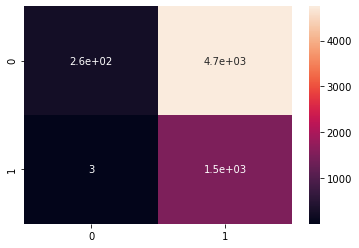

In [26]:
sns.heatmap(c_matrix[0][1],annot=True)

### QDA

<AxesSubplot:>

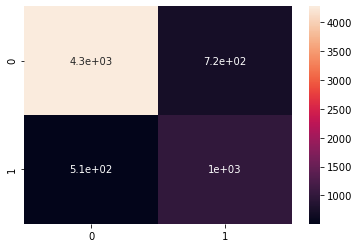

In [27]:
sns.heatmap(c_matrix[1][1],annot=True)

### Naive_Bayes

<AxesSubplot:>

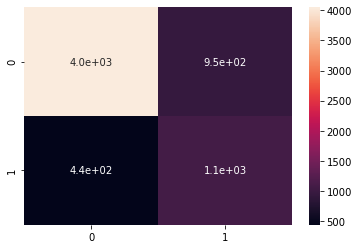

In [28]:
sns.heatmap(c_matrix[2][1],annot=True)